# BUILDING A CLOSED LOOP TESTBED

This notebook illustrates how to construct a closed loop testbed for an SBML model using a combination
of ``controlSBML`` for the open loop system (the SBML model) and ``control`` for the closed loop system.
The approach is to have ``controlSBML`` create a ``NonlinearIOSystem`` object for an SBML model
and then make use of the capabiliies of the ``control`` package to construct the testbed.

## Preliminaries

In [1]:
if False:
    !pip uninstall numpy
    !pip install -q numpy==1.21.5
    !pip install -q tellurium==2.2.2.1

In [2]:
import controlSBML as ctl

import control
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tellurium as te
from IPython.display import Image
from IPython.core.display import HTML
ctl.__version__

'1.0.11'

# Helpers

In [3]:
TEST_MODEL = """
species S1, S2, S3

S1 -> S2; k1*S1
S2 -> S3; k2*S2

S1 = 10
S2 = 0
S3 = 0
k1 = 1
k2 =2
"""

## plotTimeResponse

In [4]:
def plotTimeResponse(time_response, output_names,
                     is_legend=True, stmts=None):
    # Plots the results of running a simulation
    outputs = time_response.outputs
    times = time_response.time
    colors = ["orange", "green"]
    for idx in range(len(output_names)):
        if np.ndim(outputs) > 1:
            plt.plot(times, outputs[idx,:], c=colors[idx])
        else:
            plt.plot(times, outputs, c=colors[idx])
    if is_legend:
        _ = plt.legend(output_names)
    if stmts is None:
        stmts = []
    for stmt in stmts:
        exec(stmt)
    plt.xlabel("time")
    plt.ylabel("concentration")

In [5]:
ctlsb = ctl.ControlSBML(TEST_MODEL, input_names=["S1"], output_names=["S2"])
TEST_SYS = ctlsb.makeNonlinearIOSystem("TEST_SYS")

## plotSys

In [6]:
def plotSys(sys, times=None, initial_values=None, forced_input=None, title="", ax=None, output_labels=None, is_plot=True):
    """
    Plots the system.
    
    Parameters
    ----------
    sys: NonlinearIOSystem
    times: list-float (times for simulation)
    initial_values: list-float
    forced_input: list-float
    ax: matplotlib.Axes
    output_labels: list-str (names for output labels)
    
    Returns
    -------
    np.ndarray, np.ndarray, ax (times, predicted values, plot axis)
    """
    if times is None:
        times = np.linspace(0, 5, 100)
    if forced_input is None:
        forced_input = 0
    if initial_values is None:
        initial_values = ctl.makeStateVector(sys)
    if ax is None:
        _, ax = plt.subplots(1)
    if output_labels is None:
        output_labels = list(sys.output_labels)
    # Simulate the system
    t, y = control.input_output_response(sys, times, forced_input, initial_values)
    # Plot the response
    num_output = len(output_labels)
    if num_output == 1:
        plt.plot(t, y)
    else:
        for idx in range(num_output):
            ax.plot(t, y[idx])
    ax.legend(output_labels)
    if not is_plot:
        plt.close()
    return t, y, ax
    
# Tests
times = T = np.linspace(0, 70, 500)
times, predictions, _ = plotSys(TEST_SYS, times, is_plot=False)
assert(len(times) == len(predictions))
print("OK!")

OK!


## simulateAndPlot

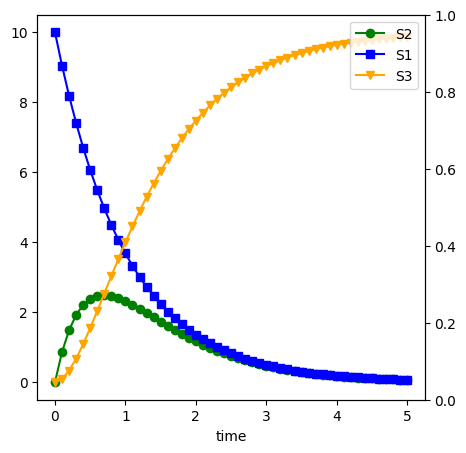

OK


In [7]:
def simulateAndPlot(model, sim_dct=None, plot_dct=None, is_plot=True):
    """
    Simulates a model and plots the results.
    
    Parameters
    ----------
    model: str or url
    """
    if sim_dct is None:
        sim_dct = {}
    if plot_dct is None:
        plot_dct = {}
    ctlsb = ctl.ControlSBML(model)
    species_names = list(ctlsb.floating_species_names)
    ctlsb = ctl.ControlSBML(model, output_names=species_names)
    sys = ctlsb.makeNonlinearIOSystem("sys")
    ts = ctl.simulateSystem(sys, **sim_dct)
    _ = ctl.plotOneTS(ts, **plot_dct)
    if not is_plot:
        plt.close()
    
# Tests
simulateAndPlot(TEST_MODEL, plot_dct={"figsize": (5,5)}, is_plot=False)
print("OK")

# Models

## Linear model

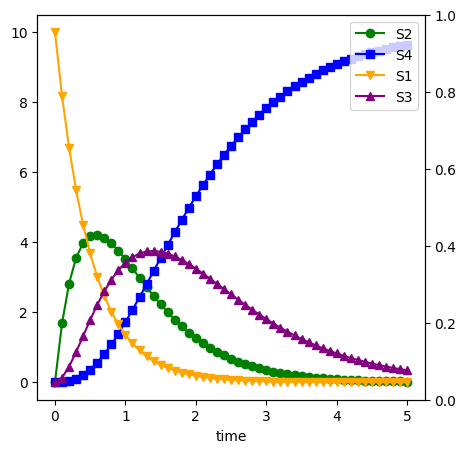

In [8]:
LINEAR_MDL = """
S1 -> S2; k1*S1
S2 -> S3; k2*S2
S3 -> S4; k3*S3

k1 = 2
k2 = 1.5
k3 = 1
S1 = 10
S2 = 0
S3 = 0
S4 = 0
"""
simulateAndPlot(LINEAR_MDL, plot_dct={"figsize": (5,5)})

## WOLF model

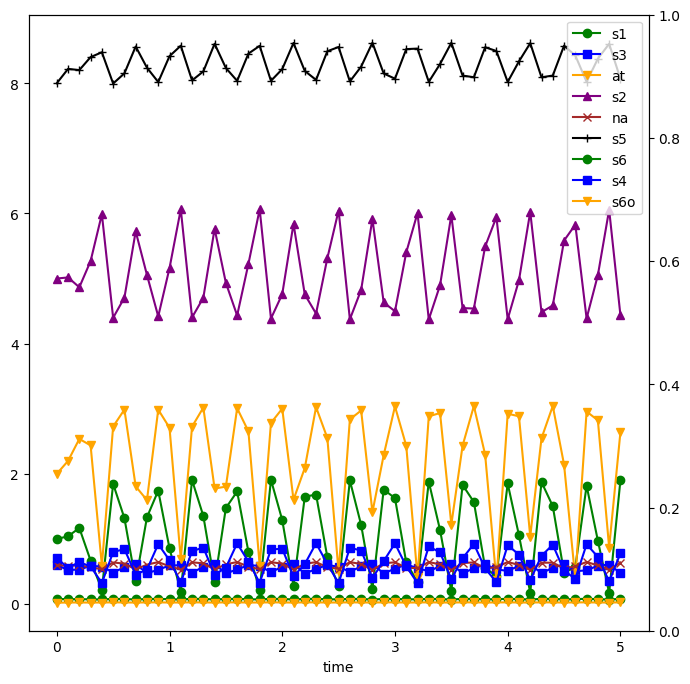

In [9]:
WOLF_CTLSB = ctl.ControlSBML("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml", 
                        input_names=["at"], output_names=["s5"])
simulateAndPlot("https://www.ebi.ac.uk/biomodels/model/download/BIOMD0000000206.2?filename=BIOMD0000000206_url.xml", plot_dct={"figsize": (8,8)})

In [10]:
WOLF_ANT = WOLF_CTLSB.antimony
print(WOLF_ANT)

// Created by libAntimony v2.13.2
model *Wolf2000_Glycolytic_Oscillations()

  // Compartments and Species:
  compartment compartment_;
  species s1 in compartment_, at_ in compartment_, s2 in compartment_, s3 in compartment_;
  species na in compartment_, s4 in compartment_, s5 in compartment_, s6 in compartment_;
  species s6o in compartment_;

  // Reactions:
  v1: s1 + 2 at_ -> s2; compartment_*k1*s1*at_/(1 + (at_/ki)^n);
  v2: s2 -> 2 s3; compartment_*k2*s2;
  v3: s3 + na -> s4 + at_; compartment_*((k31*k32*s3*na*(atot - at_) - k33*k34*s4*at_*(ntot - na))/(k33*(ntot - na) + k32*(atot - at_)));
  v4: s4 -> s5 + at_; compartment_*k4*s4*(atot - at_);
  v5: s5 -> s6; compartment_*k5*s5;
  v7: at_ -> ; compartment_*k7*at_;
  v8: s3 -> na; compartment_*k8*s3*(ntot - na);
  v9: s6o -> ; compartment_*k9*s6o;
  v10: s6 -> 0.1 s6o; compartment_*k10*(s6 - s6o);
  v6: s6 -> na; compartment_*k6*s6*(ntot - na);
  v0:  -> s1; compartment_*k0;

  // Species initializations:
  s1 = 1;
  at_ = 2;
 

# Timeseries objects

A ``Timeseries`` object is a ``pandas.DataFrame`` where the index is time in integer milliseconds.
``controlSBML`` generates and uses ``Timeseries`` objects to simplify the analysis
of closed loop systems.

In [11]:
## Simulating a system
wolf_sys = WOLF_CTLSB.makeNonlinearIOSystem("wolf")
# Simulate the system using as it is specified in the simulation. Note the warning messages.
ts = ctl.simulateSystem(wolf_sys)

In [12]:
# The output is a Timeseries. This is a dataframe where the index is time in milliseconds
ts.head()

,s5
miliseconds,
0,8.000000
100,8.220380
200,8.202220
300,8.401630
400,8.475788


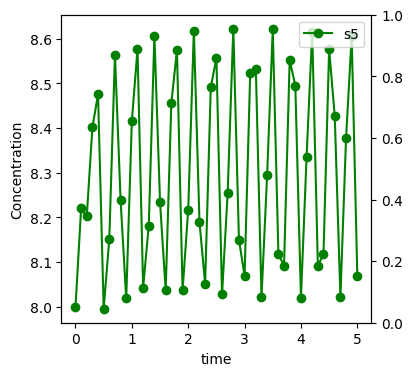

In [13]:
# We can plot any Timeseries object. Various options are available for the plot
_ = ctl.plotOneTS(ts, ylabel="Concentration", figsize=(4,4))

# CalTech Package Interconnect Objects

The CalTech package has a type of object called ``Interconnect`` that provides a way to
connect ``NonlinearIOSystem`` objects. This relies on the *name* of the ``NonlinearIOSystem``
along with its *inputs* and *outputs*.


We illustrate the use of ``Interconnect`` objects by constructing a closed loop system
for ``LINEAR_MDL`` using a proportional controller.

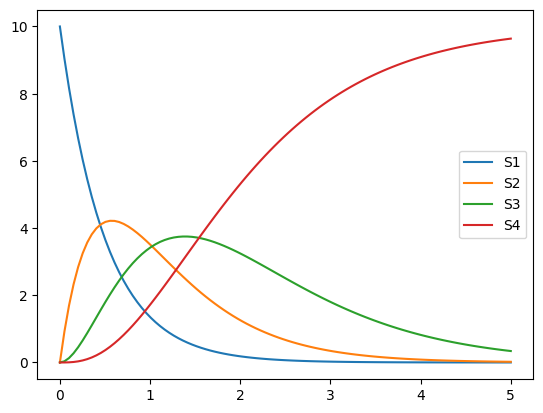

In [14]:
# Open loop system
ctlsb = ctl.ControlSBML(LINEAR_MDL,
      input_names=["S1"], output_names=["S1", "S2", "S3", "S4"])
linear_sys = ctlsb.makeNonlinearIOSystem("linear_sys")
_ = plotSys(linear_sys)

### Controller

We want to regulate the system so that S4 is 3. 

In [15]:
S4_SETPOINT = 6
# Controller
kP = 0.2
kI = 0

# Calculate derivative of state
def updfcn(t, x, y, _):
    # Accumulate the control error
    # t: float (time)
    # x: array-float (state)
    # y: array-float (output from OLS)
    # returns: array-float (derivative of state)
    dx = S4_SETPOINT - y[0]
    return dx

# Calculate output value
def outfcn(t, x, y, _):
    # Calculate the output from the input
    # t: float (time)
    # x: array-float (state)
    # e: array-float (inputs)
    # returns: array (output)
    new_err = S4_SETPOINT - y[0]
    output = kI*x[0] + kP*new_err
    return output

controller = control.NonlinearIOSystem(
  updfcn,
  outfcn,
  states=1,
  inputs=['in'],
  outputs=['out'], name='controller')

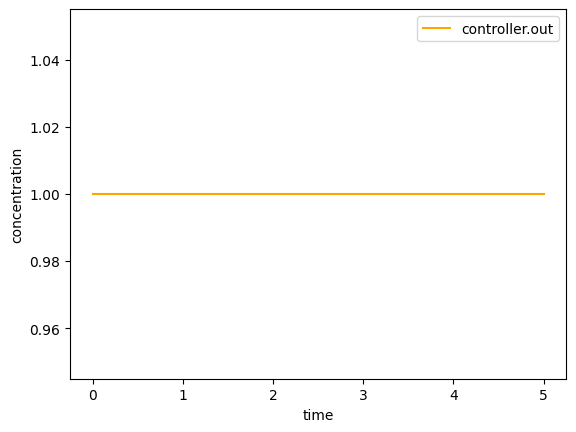

In [16]:
# Simulate a step response
times = np.linspace(0, 5, 100)
time_response = control.input_output_response(controller, times, U=1)
plotTimeResponse(time_response, ["controller.out"])

### InterconnectSystem

In [17]:
# Create the closed loop system
OUTLIST = ["linear_sys.S1", "linear_sys.S4", "linear_sys.S2", "linear_sys.S3", "controller.out"]
closed_sys = control.interconnect(
  [linear_sys, controller],       # systems
  connections=[
    ['linear_sys.S1', 'controller.out'],
    ['controller.in',  'linear_sys.S4'],
  ],
  inplist=["controller.in"],
  outlist=OUTLIST,
)

### Simulation of Closed Loop System

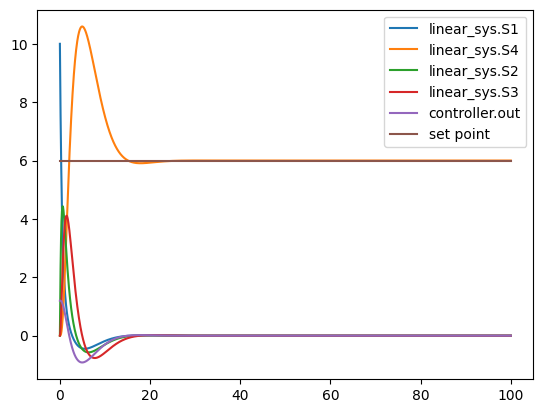

In [18]:
initial_state = ctl.makeStateVector(closed_sys)
times = np.linspace(0, 100, 2000)
time_response = control.input_output_response(closed_sys, times, X0=initial_state)
_, __, ax = plotSys(closed_sys, times=times, output_labels=OUTLIST)
ax.plot([times[0], times[-1]], [S4_SETPOINT, S4_SETPOINT])
legends = list(OUTLIST)
legends.append("set point")
ax.legend(legends)

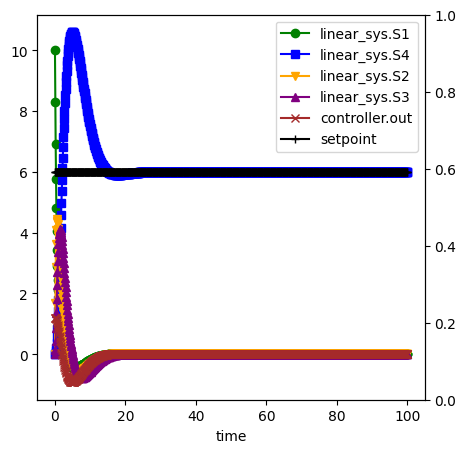

In [19]:
# Simpler approach to simulation and plotting
ts = ctl.simulateSystem(closed_sys, end_time=100, output_names=OUTLIST)
ts["setpoint"] = S4_SETPOINT
_ = ctl.plotOneTS(ts, figsize=(5,5))

# Creating a closed loop testbed for Wolf

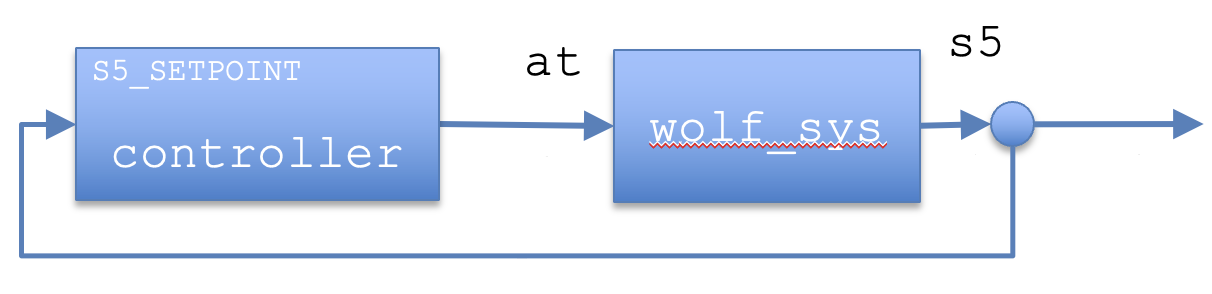

In [20]:
Image("wolf_cls1.png", width = 600, height = 300)

This example explores the use of feedback control to regulate the concentration of pyruvate in
a model of glycolytic oscillations (BioModels 206).

Pyruvate is ``s5`` in the model.
It is regulated using ATP, species ``at`` in the model.

Below is the behavior of the unregulated system.
Note the oscillations in ``s5``.

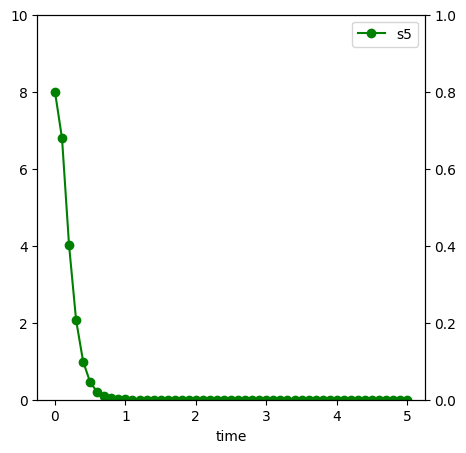

In [21]:
# Simulate the open loop system with no change in its input (at)
wolf_sys = WOLF_CTLSB.makeNonlinearIOSystem("wolf_sys", is_fixed_input_species=True)
ts = ctl.simulateSystem(wolf_sys, end_time=5)
_ = ctl.plotOneTS(ts, figsize=(5,5), ylim=[0, 10])

**Control Objectives**

1. Eliminate the oscillations from ``s5``
1. Coverge to 6.

In [22]:
S5_SETPOINT = 6

Next, we construct a PI controller.

In [23]:
def makePIController(setpoint=S5_SETPOINT, kP=20, kI=10):
    """
    Makes a PI controller
    
    Parameters
    ----------
    setpoint: float
    kP: float
    kI: float
    
    Returns
    -------
    NonlinearIOSystem
    """
    # Calculate derivative of state
    def updfcn(t, x, u, _):
        # Accumulate the control error
        # t: float (time)
        # x: array-float (state)
        # u: array-float (output from OLS)
        # returns: array-float (derivative of state)
        dx = setpoint - u[0]
        return dx

    # Calculate output value
    def outfcn(t, x, u, _):
        # Calculate the output from the input
        # t: float (time)
        # x: array-float (state)
        # u: array-float (inputs)
        # returns: array (output)
        new_err = setpoint - u[0]
        output = kI*x[0] + kP*new_err
        return output

    controller = control.NonlinearIOSystem(
      updfcn,
      outfcn,
      states=1,
      inputs=['in'],
      outputs=['out'], name='controller_sys')
    return controller

# Tests
controller = makePIController()
assert("NonlinearIOSystem" in str(type(controller)))
print("OK")

OK


We form a closed loop system so that the output of the glycolytic system, ``sys.s5``, is
the input the the controller, ``controller.in``.
And, the output of the controller, ``controller.out``, is the input the glycolytic system.

In [24]:
def makeInterconnect(wolf_sys=wolf_sys, **kwargs):
    """
    Create an Interconnect object for the Wolf closed loop system.
    
    Parameters
    ----------
    wolf_sys: NonlinearIOSystem
    kwargs: dict (arguments for makePIController)
    
    Returns
    -------
    Interconnect
    """
    controller_sys = makePIController(**kwargs)
    closed_sys = control.interconnect(
      [wolf_sys, controller_sys],       # systems
      connections=[
        ['wolf_sys.at', 'controller_sys.out'],
        ['controller_sys.in',  'wolf_sys.s5'],
      ],
      inplist=["controller_sys.in"],
      outlist=["wolf_sys.s5", 'wolf_sys.at'],
    )
    return closed_sys

# Tests
interconnect = makeInterconnect()
assert("Interconnect" in str(type(interconnect)))
print("OK!")

OK!


Now, we simulate the closed loop system.
Note that we have eliminated oscillations, and ``s5`` converges to 6.

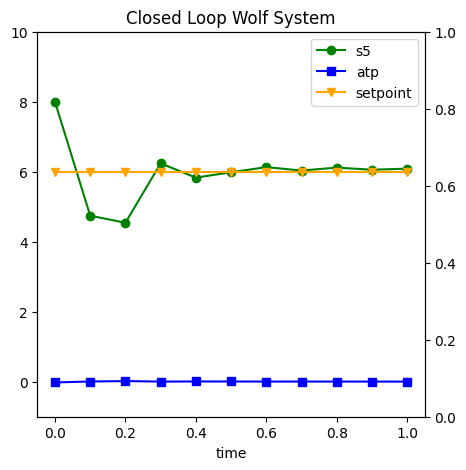

In [25]:
closed_sys = makeInterconnect(setpoint=6, kP=0.01, kI=0.05)
end_time = 1
ts = ctl.simulateSystem(closed_sys, end_time=end_time, output_names=["s5", "atp"])
#ts = ctl.simulateSystem(closed_sys, end_time=end_time)
ts["setpoint"] = S5_SETPOINT
# Plot the resultkkk
_ = ctl.plotOneTS(ts, figsize=(5,5), title="Closed Loop Wolf System", ylim=[-1, 10])

We see that the control system has achieved its objectives.